# Agroforestry Plot Generator

Before modelling climate risks, we first define **stylised, “typical” agroforestry plots** for the crops/regions of interest.  
These serve as **reference systems** for all subsequent analyses in this notebook.

The plots represent **archetypes**, not individual farms.  
They allow us to:
- Quantify shade-providing canopy and its vulnerability to hazards.
- Link risk estimates to tangible, management-relevant agroforestry configurations.

We base them on both literature and expert guidance, depending on the crop and region.

---


In [1]:
from config import DATA_DIR
import pandas as pd
import numpy as np
import requests
import time
import math
import re
from typing import Optional, Dict, List
import requests

# 🌴 Dominican Republic Agroforestry Plot Generator

Generates **typical agroforestry plots** in the Dominican Republic for coffee, cacao, or banana systems, based on **internal guidance from CEDAE/Centro Naturaleza (2023)** and plausible ecological assumptions.  
Outputs a `pandas.DataFrame` describing the main crop and associated shade trees, including densities, shading, and basic ecosystem service roles.

---

## 📚 Data Sources & Assumptions

- **Core reference**: Internal guidance document from CEDAE/Centro Naturaleza (2023), prepared in response to UNU consultant questions.  
- Based on expert knowledge of biodiversity-based agroforestry systems in DR: composition, densities, shading, plot size, and yields.  
- Not publicly available.  
- When observation points are unavailable, plot locations are generated by **jittering around a CEDAE reference centroid** within a realistic elevation range.

---

## 🌳 Systems Overview

**Coffee (mountain, upper watershed)**  
- Main crop: *Coffea arabica*  
- Permanent shade: *Inga spp.* (Guama) ~30–60% canopy cover  
- Fruit trees: avocado, citrus, sapote, breadfruit  
- Temporary shade: guandul (*Cajanus cajan*), banana/plantain (*Musa spp.*)  

**Cacao (middle watershed)**  
- Main crop: *Theobroma cacao*  
- Permanent shade: *Gliricidia sepium* (Piñón cubano) ~40–60% canopy cover  
- Fruit trees and temporary shade: same as coffee  

**Banana-based (lower watershed)**  
- Main crop: *Musa spp.*  
- Associated: coconut, cacao, citrus, soursop (*Annona muricata*), lipia  
- No permanent shade trees  

---

## 📏 Plot & Species Parameters

| System   | Plot size (ha) | Shade trees/ha | Yield (t/ha/year) | Elevation range (m) |
|----------|----------------|----------------|-------------------|---------------------|
| Coffee   | 1.0            | ~144           | ~0.73              | 600–1500            |
| Cacao    | 1.0            | ~144           | ~0.50              | 100–400             |
| Banana   | 2.5            | 0              | ~22.64             | 0–100               |

**Shading ranges:**  
- *Inga spp.*: 30–60%  
- *Gliricidia sepium*: 40–60%  
- *Cajanus cajan*: 40–60% (temporary)  
- Fruit trees: 30–50%  
- Banana/plantain: 50–70% (temporary)  

Shading is randomised within these ranges for each generated plot.

---

## 🛠️ Technical Notes

- Elevation is validated using the [Open Elevation API](https://open-elevation.com/) (can be replaced by a local DEM).  
- Species counts per plot are assigned proportionally to meet total trees/ha.  
- Plots are generated one at a time and can be concatenated for multiple synthetic examples.

---

## 📝 Output Table

| Column | Description |
|--------|-------------|
| System | Coffee / Cacao / Banana |
| Plot size (ha) | Typical plot size |
| Species | Common name |
| Scientific name | Botanical name |
| Plants/ha | Density |
| Yield (t/ha/year) | Main crop yield only |
| Per-tree shading (%) | Randomised within plausible range |
| Latitude | Sampled or from observation |
| Longitude | Sampled or from observation |
| Elevation (m) | Verified within bounds |

---

## ⚠️ Disclaimer

This is a **stylised representation of a typical plot**, not a farm census.  
Values reflect average conditions and expert input from CEDAE, with additional randomisation to represent variability.


In [2]:
# ✅ Re-define (or update) these constants before calling generate_dr_plot

from typing import Optional, List, Dict
import numpy as np
import pandas as pd

def dirichlet_counts(total: int, n: int) -> np.ndarray:
    if total <= 0 or n <= 0:
        return np.zeros(n, dtype=int)
    props = np.random.dirichlet(np.ones(n))
    return np.round(props * total).astype(int)

MAIN_CROP_SCI = {
    "Coffee": "Coffea arabica",
    "Cacao":  "Theobroma cacao",    # <-- make sure this key exists
    "Banana": "Musa spp.",          # or "Musa paradisiaca" if you prefer
}

DR_DEFAULT_COORDS = {
    "Coffee": {"lat": 19.261725, "lon": -71.278447},
    "Cacao":  {"lat": 19.379033, "lon": -71.645069},
    "Banana": {"lat": 19.644703, "lon": -71.094622},
}

DR_TYPICAL_YIELD = {
    "Coffee": 0.73,
    "Cacao":  0.50,
    "Banana": 22.64,
}

DR_SPECIES = {
    "Coffee": [
        {"Species":"Guama",          "Scientific name":"Inga spp.",          "Shade range":(30,60)},
        {"Species":"Bitter orange",  "Scientific name":"Citrus aurantium",   "Shade range":(30,50)},
        {"Species":"Sweet orange",   "Scientific name":"Citrus sinensis",    "Shade range":(30,50)},
        {"Species":"Sapote",         "Scientific name":"Pouteria sapota",    "Shade range":(30,50)},
        {"Species":"Breadfruit",     "Scientific name":"Artocarpus altilis", "Shade range":(30,50)},
        {"Species":"Avocado",        "Scientific name":"Persea americana",   "Shade range":(30,50)},
    ],
    "Cacao": [
        {"Species":"Gliricidia (Piñón cubano)", "Scientific name":"Gliricidia sepium", "Shade range":(40,60)},
        {"Species":"Bitter orange",  "Scientific name":"Citrus aurantium",   "Shade range":(30,50)},
        {"Species":"Sweet orange",   "Scientific name":"Citrus sinensis",    "Shade range":(30,50)},
        {"Species":"Sapote",         "Scientific name":"Pouteria sapota",    "Shade range":(30,50)},
        {"Species":"Breadfruit",     "Scientific name":"Artocarpus altilis", "Shade range":(30,50)},
        {"Species":"Avocado",        "Scientific name":"Persea americana",   "Shade range":(30,50)},
    ],
}

def generate_dr_plot(
    system: str,
    *,
    seed: Optional[int] = None,
    user_lat: float | None = None,
    user_lon: float | None = None,
    total_shade_trees: int = 144,
) -> pd.DataFrame:
    np.random.seed(seed)
    sys = system.capitalize()
    if sys not in ("Coffee", "Cacao", "Banana"):
        raise ValueError("system must be one of: Coffee, Cacao, Banana")

    # coords
    if user_lat is not None and user_lon is not None:
        lat, lon = float(user_lat), float(user_lon)
    else:
        ref = DR_DEFAULT_COORDS[sys]
        lat, lon = ref["lat"], ref["lon"]

    # main crop row (friendlier error if dict missing)
    if sys not in MAIN_CROP_SCI:
        raise KeyError(f"MAIN_CROP_SCI missing '{sys}'. Have: {list(MAIN_CROP_SCI.keys())}")
    plot_size = 1.0 if sys in ("Coffee", "Cacao") else 2.5
    fixed_yield = DR_TYPICAL_YIELD[sys]

    rows: List[Dict] = [{
        "Region": "DR - Cibao Noroeste",
        "System": sys,
        "Plot size (ha)": plot_size,
        "Species": f"{sys} (main crop)",
        "Scientific name": MAIN_CROP_SCI[sys],
        "Plants/ha": None,
        "Yield (t/ha/year)": round(fixed_yield, 3),
        "Per-tree shading (%)": None,
        "Latitude": lat,
        "Longitude": lon,
    }]

    # shade rows
    if sys in ("Coffee", "Cacao") and total_shade_trees > 0:
        species = DR_SPECIES[sys]
        counts = dirichlet_counts(total_shade_trees, len(species))
        for sp, n in zip(species, counts):
            shade = np.random.uniform(*sp["Shade range"]) if sp["Shade range"] else None
            rows.append({
                "Region": "DR - Cibao Noroeste",
                "System": sys,
                "Plot size (ha)": plot_size,
                "Species": sp["Species"],
                "Scientific name": sp["Scientific name"],
                "Plants/ha": int(n),
                "Yield (t/ha/year)": None,
                "Per-tree shading (%)": (round(shade, 1) if shade is not None else None),
                "Latitude": lat,
                "Longitude": lon,
            })

    return pd.DataFrame(rows)



README – Agroforestry Scenarios for DR – Cibao Noroeste
================================================================

This script generates *synthetic agroforestry system compositions* for Coffee and Cacao
in the DR – Cibao Noroeste region, based on fixed geographic locations sampled from recent
GBIF observations. For each main crop, we build a multi-sheet Excel workbook containing:

1. **present** – Baseline plot compositions as generated by `generate_dr_plot()`.
2. **heat** – Present composition adjusted for a hot year:
    - Increased abundance of known heat-buffering species (Inga spp., breadfruit, sapote).
    - Reduced abundance of heat-sensitive species (citrus, slightly avocado).
    - Optional +10% increase in per-tree shading.
3. **drought** – Present composition adjusted for a dry year:
    - Boost to drought-tolerant shade species (Inga spp., Gliricidia).
    - Reduced abundance of drought-sensitive species (citrus, slightly avocado).
    - Optional -10% adjustment to per-tree shading.
4. **switch** – Replacement of the main crop at the same coordinates:
    - Coffee → Cacao with a new associated shade tree composition.
    - Cacao → Coffee likewise.
    - Associated agroforestry species are generated fresh for the new main crop.

**How locations are chosen:**
- We load all GBIF observation records from `species_occurrences_combined_cleaned.csv`.
- Filter to DR – Cibao Noroeste bounding box.
- For each crop, select the most recent `points_per_sheet` observations
  of the *main crop species* (Coffee = `Coffea arabica`, Cacao = `Theobroma cacao`).
- These lat/lon points are reused across all sheets for that crop.

**Output:**
- One `.xlsx` file per main crop, saved to `DATA_DIR / agroforestry_systems`.
- Filenames are date-tagged: `{YYYYMMDD}__{CROP}__DR_Cibao_Noroeste.xlsx`.
- Each sheet corresponds to one scenario.

**Key functions:**
- `generate_dr_plot(system, seed)` → Generates a single-plot DataFrame for the given main crop.
- `apply_species_multipliers_one_plot(...)` → Applies per-species adjustments for scenarios.
- `transform_sheet_by_plot(...)` → Preserves per-plot totals when scaling species.
- `build_sheet_*` → Scenario-specific builders.

**Notes:**
- Scenario multipliers match either `Scientific name` or `Species` strings in the sheet.
- Total number of shade trees per plot is preserved after scaling unless explicitly changed.
- Per-tree shading (%) is adjusted only if the column is present in the base sheet.

"""


In [3]:
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
from config import DATA_DIR

# ---- I/O ----
obs_path = DATA_DIR / "species_occurrences_combined_cleaned.csv"
output_dir =  Path("agroforestry_systems")
output_dir.mkdir(parents=True, exist_ok=True)

region_name = "DR - Cibao Noroeste"
systems = ["Coffee", "Cacao"]           # Banana ignored for now
points_per_sheet = 20
date_tag = datetime.now().strftime("%Y%m%d")

# Main-crop scientific names (for filtering obs)
MAIN_SCI = {
    "Coffee": "Coffea arabica",
    "Cacao":  "Theobroma cacao",
}

# DR Cibao Noroeste bbox (adjust if needed)
lon_min, lat_min, lon_max, lat_max = -71.8, 19.0, -70.9, 20.1

# --------- Scenario multipliers (match by Scientific name; fallback to Species) ---------
# Heat-buffering: boost Inga, breadfruit, sapote; reduce citrus; avocado slightly down; Gliricidia steady
SCENARIO_HEAT = {
    "Inga vera": 1.30, "Inga spp.": 1.30,
    "Artocarpus altilis": 1.30,
    "Pouteria sapota": 1.20,
    "Persea americana": 0.90,
    "Citrus sinensis": 0.75,
    "Citrus aurantium": 0.80,
    "Gliricidia sepium": 1.00,
}
HEAT_SHADE_ADJ = +0.10  # optional: +10% per-tree shade

# Drought-year: boost Inga, modest boost Gliricidia; reduce citrus; avocado slightly down
SCENARIO_DROUGHT = {
    "Inga vera": 1.25, "Inga spp.": 1.25,
    "Gliricidia sepium": 1.10,
    "Artocarpus altilis": 1.05,
    "Pouteria sapota": 1.05,
    "Persea americana": 0.90,
    "Citrus sinensis": 0.70,
    "Citrus aurantium": 0.75,
}
DROUGHT_SHADE_ADJ = -0.10  # optional: -10% per-tree shade

# ---- helpers for scenarios ----
def apply_species_multipliers_one_plot(df_plot: pd.DataFrame,
                                       multipliers: dict[str, float],
                                       keep_total: bool = True,
                                       shade_adj: float | None = None) -> pd.DataFrame:
    """Apply per-species multipliers within a single-plot DF and keep total shade trees constant."""
    df = df_plot.copy()
    main_label = f"{df['System'].iloc[0]} (main crop)"
    mask = df["Species"] != main_label
    if mask.sum() == 0:
        return df

    scaled = []
    for i, row in df.loc[mask].iterrows():
        sci = str(row.get("Scientific name", ""))
        lbl = str(row.get("Species", ""))
        mult = multipliers.get(sci, multipliers.get(lbl, 1.0))
        plants = int(row.get("Plants/ha") or 0)
        scaled.append((i, max(0, int(round(plants * mult)))))

    if keep_total:
        old_total = int(df.loc[mask, "Plants/ha"].fillna(0).sum())
        new_total = int(sum(v for _, v in scaled))
        if new_total > 0 and new_total != old_total:
            k = old_total / new_total
            scaled = [(i, max(0, int(round(v * k)))) for i, v in scaled]

    for i, v in scaled:
        df.at[i, "Plants/ha"] = v

    if shade_adj is not None and "Per-tree shading (%)" in df.columns:
        df.loc[mask, "Per-tree shading (%)"] = (
            df.loc[mask, "Per-tree shading (%)"].astype(float) * (1.0 + shade_adj)
        ).round(1)

    return df

def transform_sheet_by_plot(df_sheet: pd.DataFrame,
                            multipliers: dict[str, float],
                            shade_adj: float | None) -> pd.DataFrame:
    """Apply multipliers per Plot ID so totals are preserved per plot."""
    if df_sheet.empty:
        return df_sheet
    out = []
    for _, grp in df_sheet.groupby("Plot ID", sort=False):
        out.append(apply_species_multipliers_one_plot(grp, multipliers, keep_total=True, shade_adj=shade_adj))
    return pd.concat(out, ignore_index=True)

# ---- load observations & pick locations per crop (same set used across sheets) ----
df_obs = pd.read_csv(obs_path)

# Harmonize expected columns
if "species" in df_obs.columns and "species_query" not in df_obs.columns:
    df_obs = df_obs.rename(columns={"species": "species_query"})
if "Longitude" in df_obs.columns and "decimalLongitude" not in df_obs.columns:
    df_obs = df_obs.rename(columns={"Longitude": "decimalLongitude"})
if "Latitude" in df_obs.columns and "decimalLatitude" not in df_obs.columns:
    df_obs = df_obs.rename(columns={"Latitude": "decimalLatitude"})

# Restrict to DR bbox
df_obs_dr = df_obs[
    df_obs["decimalLongitude"].between(lon_min, lon_max) &
    df_obs["decimalLatitude"].between(lat_min, lat_max)
].copy()

# Build fixed location sets per crop
locs_per_crop: dict[str, list[tuple[float, float]]] = {}
for sys in systems:
    sci = MAIN_SCI[sys]
    dfc = df_obs_dr[df_obs_dr["species_query"] == sci].copy()
    if "year" in dfc.columns:
        dfc = dfc.sort_values("year", ascending=False)
    locs = list(zip(dfc["decimalLatitude"].tolist(), dfc["decimalLongitude"].tolist()))[:points_per_sheet]
    locs_per_crop[sys] = locs
    print(f"📍 {sys}: {len(locs)} DR points selected")

# ---- builders ----
def build_sheet_present(system: str, locs: list[tuple[float, float]]) -> pd.DataFrame:
    rows = []
    for i, (lat, lon) in enumerate(locs, start=1):
        df_plot = generate_dr_plot(system, seed=42 + i)
        df_plot["Region"] = region_name
        df_plot["Latitude"] = lat
        df_plot["Longitude"] = lon
        df_plot.insert(0, "Plot ID", f"{system}_plot_{i:03d}")
        rows.append(df_plot)
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

def build_sheet_heat(system: str, base_sheet: pd.DataFrame) -> pd.DataFrame:
    return transform_sheet_by_plot(base_sheet, SCENARIO_HEAT, HEAT_SHADE_ADJ)

def build_sheet_drought(system: str, base_sheet: pd.DataFrame) -> pd.DataFrame:
    return transform_sheet_by_plot(base_sheet, SCENARIO_DROUGHT, DROUGHT_SHADE_ADJ)

def build_sheet_switch(system: str, locs: list[tuple[float, float]]) -> pd.DataFrame:
    """Coffee→Cacao or Cacao→Coffee at the same coordinates."""
    target = "Cacao" if system == "Coffee" else "Coffee"
    rows = []
    for i, (lat, lon) in enumerate(locs, start=1):
        df_plot = generate_dr_plot(target, seed=101 + i)
        df_plot["Region"] = region_name
        df_plot["Latitude"] = lat
        df_plot["Longitude"] = lon
        df_plot.insert(0, "Plot ID", f"{target}_from{system}_plot_{i:03d}")
        rows.append(df_plot)
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

# ---- write one workbook per crop; locations fixed across sheets ----
for sys in systems:
    locs = locs_per_crop.get(sys, [])
    if not locs:
        print(f"⚠️ No observation points for {sys} in DR bbox — skipping.")
        continue

    output_file = output_dir / f"{date_tag}__{sys}__DR_Cibao_Noroeste.xlsx"
    present = build_sheet_present(sys, locs)

    with pd.ExcelWriter(output_file) as w:
        present.to_excel(w, sheet_name="present", index=False)
        build_sheet_heat(sys, present).to_excel(w, sheet_name="heat", index=False)
        build_sheet_drought(sys, present).to_excel(w, sheet_name="drought", index=False)
        # explicit switch sheet names
        if sys == "Coffee":
            build_sheet_switch(sys, locs).to_excel(w, sheet_name="coffee_to_cacao", index=False)
        else:  # sys == "Cacao"
            build_sheet_switch(sys, locs).to_excel(w, sheet_name="cacao_to_coffee", index=False)

    print(f"✅ Saved {sys}: {output_file}")


📍 Coffee: 4 DR points selected
📍 Cacao: 3 DR points selected
✅ Saved Coffee: agroforestry_systems/20250812__Coffee__DR_Cibao_Noroeste.xlsx
✅ Saved Cacao: agroforestry_systems/20250812__Cacao__DR_Cibao_Noroeste.xlsx


# 🇬🇹 Guatemala — Coffee & Cacao Agroforestry Plot Generators

These scripts generate **stylised agroforestry plots** for coffee (*Coffea arabica*) in the Western Highlands and cacao (*Theobroma cacao*) in Alta Verapaz, Guatemala, using published field studies as baselines.  
Outputs are `pandas.DataFrame` objects describing the main crop and associated shade-tree species, with densities, shading values, and location metadata.

---

## 📚 Data Sources

### Coffee (Western Highlands)
- **Rice, R. A. (2008; 2011)** — surveys of 153 coffee farmers in Guatemala’s Western Highlands.
  - Typical farm: ~3.5 ha; elevation: 900–1,400 m; shade cover: ~30–50%
  - Yield: ~0.78 t/ha/year
  - Shade tree density: ~184 trees/ha
  - *Inga spp.* dominant (~60% of shade trees), plus timber and minor fruit species

### Cacao (Alta Verapaz)
- **Villanueva-González, C. E., et al. (2023)**. *Botanical diversity, structure and composition in cocoa agroforest systems in Alta Verapaz, Guatemala.* Scientia Agropecuaria, 14(2), 223–234.  
  [https://doi.org/10.17268/sci.agropecu.2023.020](https://doi.org/10.17268/sci.agropecu.2023.020)
  - Based on 70 cacao agroforestry plots across 4 municipalities
  - Reports species richness, tree density, and structural traits

---

## 🌳 Plot Composition

### Coffee — Western Highlands
| Species | Scientific name | Target density (trees/ha) | Per-tree shading (%) |
|---|---|---:|---:|
| Guama | *Inga spp.* | 111 | 45–60 |
| Cedar | *Cedrela odorata* | 30 | 30–40 |
| Oak | *Quercus spp.* | 20 | 30–40 |
| Walnut | *Juglans spp.* | 15 | 30–40 |
| Banana | *Musa spp.* | 10 | 20–30 |
| Avocado | *Persea americana* | 8 | 30–40 |
| Citrus | *Citrus spp.* | 6 | 30–40 |
| Pacaya | *Chamedorea spp.* | 5 | 20–30 |
| Hog plum | *Spondias mombins* | 5 | 20–30 |

---

### Cacao — Alta Verapaz
| Species | Scientific name | Shade range (%) |
|---|---|---:|
| Gliricidia | *Gliricidia sepium* | 40–60 |
| Mahogany | *Swietenia macrophylla* | 50–70 |
| Cedar | *Cedrela odorata* | 40–60 |
| Copal | *Protium copal* | 30–50 |
| Cordia | *Cordia alliodora* | 40–60 |
| Inga | *Inga sapindoides* | 50–70 |
| Avocado | *Persea americana* | 40–60 |
| Sapote | *Pouteria sapota* | 40–60 |
| Mango | *Mangifera indica* | 50–70 |

---

## 📏 Core Assumptions

| Parameter           | Coffee (WH)       | Cacao (Alta Verapaz) |
|---------------------|-------------------|----------------------|
| Plot size           | 3.5 ha            | 1.0 ha               |
| Yield               | 0.78 t/ha/year    | 0.40 t/ha/year       |
| Shade tree density  | ~184 trees/ha     | 151 trees/ha         |
| Elevation range     | 900–1,400 m       | 132–500 m            |
| Lat/lon range       | given point       | 15.4–15.8° N / –90.3 to –89.8° |

---

## 🛠️ Generator Behaviour

- **Location:**  
  - Coffee generator takes a **given point** (lat, lon).  
  - Cacao generator samples a location within the Alta Verapaz bounding box.
- **Shade densities:**  
  - Coffee: target densities varied ±20% (5% chance to omit minor species).  
  - Cacao: total shade trees = 151, distributed via random Dirichlet proportions.
- **Per-tree shading:**  
  - Sampled within species-specific ranges to keep aggregate canopy realistic.
- **Elevation:**  
  - Coffee generator can fetch elevation (optional).  
  - Cacao uses sampled elevation within literature range.

---

## 📄 Output Columns

Region / System / Plot size (ha) / Species / Scientific name /
Plants/ha / Yield (t/ha/year) / Per-tree shading (%) /
Latitude / Longitude / Elevation (m)


---

## ⚠️ Notes

- These are **stylised representations** from literature, **not** actual farm censuses.
- Randomisation ensures plausible heterogeneity between generated plots.
- Intended for **scenario building and modelling**, not exact inventories.

---

## 📑 Suggested Citations

Rice, R. A. (2011). *Agroforestry Systems*, 83(1), 41–49. https://doi.org/10.1007/s10457-011-9385-4  
Rice, R. A. (2008). *Agricultural intensification within agroforestry: Shade coffee in Central America.* University of California.  
Villanueva-González, C. E., et al. (2023). *Botanical diversity, structure and composition in cocoa agroforest systems in Alta Verapaz, Guatemala.* Scientia Agropecuaria, 14(2), 223–234.


In [4]:
# === Guatemala generators & constants (present-only, deterministic) ===
from typing import Optional, List, Dict
import numpy as np
import pandas as pd

# Standardised main-crop names
GTM_MAIN_CROP_SCI = {
    "Coffee": "Coffea arabica",
    "Cacao":  "Theobroma cacao",
}

# ---------- Coffee — Western Highlands ----------
GTM_WH_REGION     = "GTM - Western Highlands"
GTM_WH_PLOT_SIZE  = 3.5        # ha
GTM_WH_YIELD      = 0.78       # t/ha/yr

# Target densities and shade ranges
GTM_WH_SPECIES: List[Dict] = [
    {"Species": "Guama",     "Scientific name": "Inga spp.",            "Density/ha": 111, "Shade range": (45, 60)},
    {"Species": "Cedar",     "Scientific name": "Cedrela odorata",      "Density/ha":  30, "Shade range": (30, 40)},
    {"Species": "Oak",       "Scientific name": "Quercus spp.",         "Density/ha":  20, "Shade range": (30, 40)},
    {"Species": "Walnut",    "Scientific name": "Juglans spp.",         "Density/ha":  15, "Shade range": (30, 40)},
    {"Species": "Banana",    "Scientific name": "Musa paradisiaca",     "Density/ha":  10, "Shade range": (20, 30)},
    {"Species": "Avocado",   "Scientific name": "Persea americana",     "Density/ha":   8, "Shade range": (30, 40)},
    {"Species": "Citrus",    "Scientific name": "Citrus sinensis",      "Density/ha":   6, "Shade range": (30, 40)},
    {"Species": "Pacaya",    "Scientific name": "Chamaedorea spp.",     "Density/ha":   5, "Shade range": (20, 30)},
    {"Species": "Hog plum",  "Scientific name": "Spondias mombin",      "Density/ha":   5, "Shade range": (20, 30)},
]

def generate_guatemala_coffee_plot_at_point(
    *,
    lat: float,
    lon: float,
    seed: Optional[int] = None,
    density_variation: float = 0.0,   # 0 → deterministic (exact targets)
    skip_minor_prob: float = 0.0      # 0 → keep all species
) -> pd.DataFrame:
    """
    One stylised Guatemala WH coffee plot at (lat, lon).
    Fixed yield & plot size. By default deterministic: target densities, mid-range shade.
    """
    np.random.seed(seed)

    rows: List[Dict] = [{
        "Region": GTM_WH_REGION,
        "System": "Coffee",
        "Plot size (ha)": GTM_WH_PLOT_SIZE,
        "Species": "Coffee (main crop)",
        "Scientific name": GTM_MAIN_CROP_SCI["Coffee"],
        "Plants/ha": None,
        "Yield (t/ha/year)": round(GTM_WH_YIELD, 3),
        "Per-tree shading (%)": None,
        "Latitude": float(lat),
        "Longitude": float(lon),
        "Elevation (m)": None,
    }]

    scale = 1.0 + (0.0 if density_variation == 0 else float(np.random.uniform(-density_variation, density_variation)))
    shade_mid = lambda a, b: round((a + b) / 2.0, 1)

    for sp in GTM_WH_SPECIES:
        if skip_minor_prob > 0 and np.random.rand() < skip_minor_prob:
            continue
        n = int(round(sp["Density/ha"] * scale))
        rows.append({
            "Region": GTM_WH_REGION,
            "System": "Coffee",
            "Plot size (ha)": GTM_WH_PLOT_SIZE,
            "Species": sp["Species"],
            "Scientific name": sp["Scientific name"],
            "Plants/ha": n,
            "Yield (t/ha/year)": None,
            "Per-tree shading (%)": shade_mid(*sp["Shade range"]),
            "Latitude": float(lat),
            "Longitude": float(lon),
            "Elevation (m)": None,
        })

    return pd.DataFrame(rows)

# ---------- Cacao — Alta Verapaz (deterministic) ----------
GTM_AV_REGION       = "GTM - Alta Verapaz"
GTM_CACAO_PLOT_SIZE = 1.0      # ha
GTM_CACAO_YIELD     = 0.50     # t/ha/yr (rounding your 0.4/0.5 to a fixed "present" value)
GTM_CACAO_TOTAL_TREES = 151

# Species list (Villanueva-González et al. 2023) + deterministic weights → counts
GTM_AV_CACAO_SPECIES: List[Dict] = [
    {"Species": "Gliricidia", "Scientific name": "Gliricidia sepium",   "Shade range": (40, 60), "w": 0.25},
    {"Species": "Mahogany",   "Scientific name": "Swietenia macrophylla","Shade range": (50, 70), "w": 0.12},
    {"Species": "Cedar",      "Scientific name": "Cedrela odorata",     "Shade range": (40, 60), "w": 0.10},
    {"Species": "Copal",      "Scientific name": "Protium copal",       "Shade range": (30, 50), "w": 0.08},
    {"Species": "Cordia",     "Scientific name": "Cordia alliodora",    "Shade range": (40, 60), "w": 0.10},
    {"Species": "Inga",       "Scientific name": "Inga sapindoides",    "Shade range": (50, 70), "w": 0.15},
    {"Species": "Avocado",    "Scientific name": "Persea americana",    "Shade range": (40, 60), "w": 0.08},
    {"Species": "Sapote",     "Scientific name": "Pouteria sapota",     "Shade range": (40, 60), "w": 0.06},
    {"Species": "Mango",      "Scientific name": "Mangifera indica",    "Shade range": (50, 70), "w": 0.06},
]

def _deterministic_counts_from_weights(total: int, weights: list[float]) -> list[int]:
    arr = np.array(weights, dtype=float)
    arr = arr / arr.sum()
    raw = arr * total
    floored = np.floor(raw).astype(int)
    remainder = total - floored.sum()
    # distribute remaining by largest fractional parts
    frac_idx = np.argsort(-(raw - floored))
    for k in range(remainder):
        floored[frac_idx[k]] += 1
    return floored.tolist()

def generate_guatemala_cacao_plot_at_point(
    *,
    lat: float,
    lon: float,
    seed: Optional[int] = None,
) -> pd.DataFrame:
    """
    One stylised Guatemala cacao plot at (lat, lon) — AV-style composition.
    Fixed yield & plot size. Deterministic counts (weights → 151 trees), mid-range shade.
    """
    np.random.seed(seed)

    rows: List[Dict] = [{
        "Region": GTM_AV_REGION,
        "System": "Cacao",
        "Plot size (ha)": GTM_CACAO_PLOT_SIZE,
        "Species": "Cacao (main crop)",
        "Scientific name": GTM_MAIN_CROP_SCI["Cacao"],
        "Plants/ha": None,
        "Yield (t/ha/year)": round(GTM_CACAO_YIELD, 3),
        "Per-tree shading (%)": None,
        "Latitude": float(lat),
        "Longitude": float(lon),
        "Elevation (m)": None,
    }]

    shade_mid = lambda a, b: round((a + b) / 2.0, 1)
    weights = [sp["w"] for sp in GTM_AV_CACAO_SPECIES]
    counts = _deterministic_counts_from_weights(GTM_CACAO_TOTAL_TREES, weights)

    for sp, n in zip(GTM_AV_CACAO_SPECIES, counts):
        rows.append({
            "Region": GTM_AV_REGION,
            "System": "Cacao",
            "Plot size (ha)": GTM_CACAO_PLOT_SIZE,
            "Species": sp["Species"],
            "Scientific name": sp["Scientific name"],
            "Plants/ha": int(n),
            "Yield (t/ha/year)": None,
            "Per-tree shading (%)": shade_mid(*sp["Shade range"]),
            "Latitude": float(lat),
            "Longitude": float(lon),
            "Elevation (m)": None,
        })

    return pd.DataFrame(rows)


NameError: name 'world' is not defined

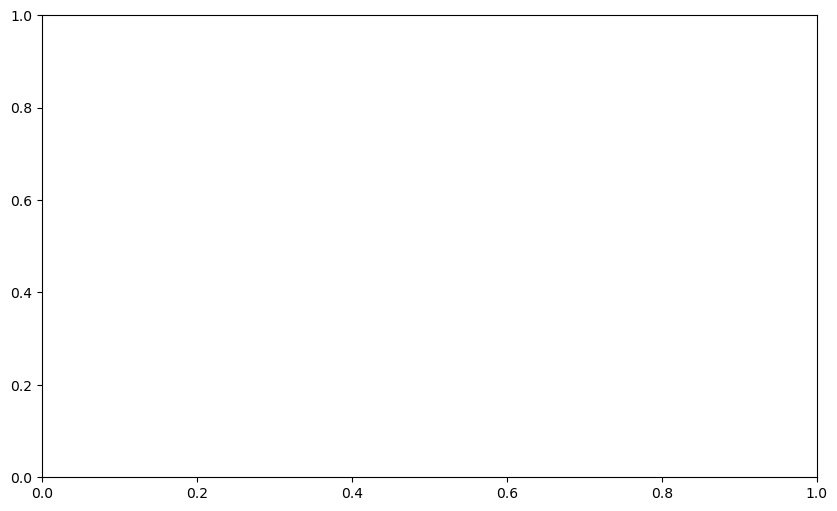

In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load the coffee locations
df = pd.read_csv(DATA_DIR / "CoffeeCAM_anonymized.csv")

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(ax=ax, color="lightgrey", edgecolor="white")
gdf.plot(ax=ax, color="darkgreen", markersize=8)

# Set zoom: approx Central America (adjust if needed)
ax.set_xlim([-94, -60])   # longitude
ax.set_ylim([7, 20])      # latitude

ax.set_title("Coffee Plot Locations in Central America")
plt.show()

# 📑 Guatemala Coffee & Cacao Agroforestry — Multi-Scenario Workbook Generator

This step takes the **full set of Guatemala agroforestry plots** for **Coffee** (Western Highlands) and **Cacao** (Alta Verapaz) —  
where each row describes one species in a given plot — and produces a single Excel workbook for each system with **four sheets**:

1. **present** — plots exactly as generated from the relevant baseline generator  
   - Coffee: Rice (2008, 2011) Western Highlands structure  
   - Cacao: Villanueva-González et al. (2023) Alta Verapaz structure
2. **alternative_1** — **fruit-heavy scenario**: more fruit trees, slightly fewer timber trees, nitrogen-fixers unchanged.
3. **alternative_2** — **timber-heavy scenario**: more timber trees, slightly fewer fruit trees, nitrogen-fixers unchanged.
4. **alternative_3** — **cross-system swap**:  
   - For Coffee → replaced with a typical Cacao plot (and associated cacao shade-tree mix).  
   - For Cacao → replaced with a typical Coffee plot (and associated coffee shade-tree mix).

---

## 🔍 How it works

- **Input**:  
  - A dataframe of all plots for the target system, each with a unique `"Plot ID"`.  
    Each plot has one row for the **main crop** (*Coffea arabica* or *Theobroma cacao*) and multiple rows for associated shade-tree species.  
    Must contain columns: `"Species"`, `"Plants/ha"`, and `"Plot ID"`.
- **Functional groups**:  
  - Shade-tree species are classified into functional groups (`fruit`, `timber`, `nfixer`, `other`).
- **Scenarios**:  
  - Alternatives 1 and 2 apply **multipliers** to `Plants/ha` by functional group, then renormalise to keep **total shade-tree density constant** per plot.
  - Alternative 3 completely replaces the plot composition with that of the **other system** (coffee ↔ cacao), keeping the plot coordinates identical.
  - **Main crop rows** are untouched except in Alternative 3, where they are swapped for the other crop.
- **Output**:  
  - One Excel workbook per system (Coffee, Cacao) saved in `./data/agroforestry_systems/`.  
  - Each sheet contains *all plots* stacked together, with a `"Scenario"` column indicating the type.

---

## 📊 Why these scenarios?

The three alternatives explore **structural changes** to agroforestry plots, allowing scenario-based analysis of ecosystem services, shade cover, and economic trade-offs:

- **Fruit-heavy** — increases immediate food/income potential from fruit trees.
- **Timber-heavy** — increases long-term wood value.
- **Cross-system swap** — tests implications of replacing a coffee system with cacao (or vice versa) at the same coordinates.

---

## ⚠️ Notes

- Shading percentages and yields are unchanged in Alternatives 1 & 2;  
  in Alternative 3, they reflect the swapped system’s baseline.
- Plot coordinates remain identical across all sheets for a given workbook, enabling direct scenario comparisons.
- Ensure baseline plot generators for both systems are run before scenario generation.

---


In [8]:
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
from config import DATA_DIR

# ---------- I/O ----------
obs_path = DATA_DIR / "species_occurrences_combined_cleaned.csv"
output_dir.mkdir(parents=True, exist_ok=True)
date_tag = datetime.now().strftime("%Y%m%d")

# ---------- Regions & bboxes ----------
REGION_WH = "GTM - Western Highlands"
REGION_AV = "GTM - Alta Verapaz"

# Coffee (WH) bbox: Huehuetenango/Quiché/San Marcos/Quetzaltenango/Totonicapán/Solola
BBOX_WH = (-92.6, 14.2, -90.3, 15.9)
# Cacao (AV) bbox: broader Alta Verapaz window
BBOX_AV = (-90.9, 15.2, -89.6, 16.5)

POINTS_PER_SHEET = 20

MAIN_SCI = {
    "Coffee": "Coffea arabica",
    "Cacao":  "Theobroma cacao",
}

# ---------- Scenario multipliers ----------
# Coffee scenarios (match by Scientific name, fallback to Species)
COFFEE_SCENARIO_HEAT = {
    "Inga spp.": 1.30,
    "Spondias mombin": 1.50,
    "Musa paradisiaca": 1.20,
    "Persea americana": 0.90,
    "Quercus spp.": 0.60,
    "Juglans spp.": 0.70,
    "Citrus sinensis": 0.70,
    "Cedrela odorata": 1.00,
    "Chamaedorea spp.": 0.85,
}
COFFEE_HEAT_SHADE_ADJ = +0.10

COFFEE_SCENARIO_DROUGHT = {
    "Inga spp.": 1.25,
    "Cedrela odorata": 1.20,
    "Spondias mombin": 1.20,
    "Musa paradisiaca": 0.60,
    "Citrus sinensis": 0.70,
    "Persea americana": 0.90,
    "Quercus spp.": 0.90,
    "Juglans spp.": 0.90,
    "Chamaedorea spp.": 0.80,
}
COFFEE_DROUGHT_SHADE_ADJ = -0.10

# Cacao scenarios (AV-style composition)
CACAO_SCENARIO_HEAT = {
    "Gliricidia sepium": 1.10,
    "Inga sapindoides": 1.25,
    "Persea americana": 0.90,
    "Citrus sinensis": 0.80,
    "Pouteria sapota": 1.10,
    "Mangifera indica": 0.90,
    "Cordia alliodora": 1.00,
    "Swietenia macrophylla": 1.00,
    "Protium copal": 1.00,
    "Musa paradisiaca": 1.10,
}
CACAO_HEAT_SHADE_ADJ = +0.10

CACAO_SCENARIO_DROUGHT = {
    "Gliricidia sepium": 1.15,
    "Inga sapindoides": 1.20,
    "Persea americana": 0.90,
    "Citrus sinensis": 0.75,
    "Pouteria sapota": 1.05,
    "Mangifera indica": 0.90,
    "Cordia alliodora": 1.00,
    "Swietenia macrophylla": 1.00,
    "Protium copal": 1.00,
    "Musa paradisiaca": 0.70,
}
CACAO_DROUGHT_SHADE_ADJ = -0.10

# ---------- helpers ----------
def _harmonize_cols(df: pd.DataFrame) -> pd.DataFrame:
    rename_map = {
        "species": "species_query", "scientificName": "species_query",
        "Longitude": "decimalLongitude", "lon": "decimalLongitude", "lng": "decimalLongitude",
        "Latitude": "decimalLatitude",   "lat": "decimalLatitude",
    }
    for k, v in rename_map.items():
        if k in df.columns and v not in df.columns:
            df = df.rename(columns={k: v})
    return df

def _filter_bbox_points(df: pd.DataFrame, sci: str, bbox: tuple, n: int) -> list[tuple[float, float]]:
    lon_min, lat_min, lon_max, lat_max = bbox
    dfr = df[
        (df["species_query"] == sci) &
        df["decimalLongitude"].between(lon_min, lon_max) &
        df["decimalLatitude"].between(lat_min, lat_max)
    ].copy()
    if "year" in dfr.columns:
        dfr = dfr.sort_values("year", ascending=False)
    # ~1 km de-dup grid
    cell_deg = 0.01
    dfr["_lonc"] = (dfr["decimalLongitude"] / cell_deg).round()
    dfr["_latc"] = (dfr["decimalLatitude"]  / cell_deg).round()
    dfr = dfr.drop_duplicates(subset=["_lonc", "_latc"])
    pts = list(zip(dfr["decimalLatitude"].tolist(), dfr["decimalLongitude"].tolist()))
    return pts[:n]

def _apply_species_multipliers(df_sheet: pd.DataFrame, multipliers: dict[str, float], shade_adj: float | None) -> pd.DataFrame:
    if df_sheet.empty:
        return df_sheet.copy()
    # Determine main label by the system present in each plot
    out = []
    for pid, grp in df_sheet.groupby("Plot ID", sort=False):
        df = grp.copy()
        sys = df["System"].iloc[0]
        main_label = f"{sys} (main crop)"
        mask = df["Species"] != main_label
        if mask.sum() == 0:
            out.append(df)
            continue

        scaled = []
        for i, row in df.loc[mask].iterrows():
            sci = str(row.get("Scientific name", ""))
            lbl = str(row.get("Species", ""))
            mult = multipliers.get(sci, multipliers.get(lbl, 1.0))
            plants = int(row.get("Plants/ha") or 0)
            scaled.append((i, max(0, int(round(plants * mult)))))

        # keep total constant
        old_total = int(df.loc[mask, "Plants/ha"].fillna(0).sum())
        new_total = int(sum(v for _, v in scaled))
        if new_total > 0 and new_total != old_total:
            k = old_total / new_total
            scaled = [(i, max(0, int(round(v * k)))) for i, v in scaled]

        for i, v in scaled:
            df.at[i, "Plants/ha"] = v

        if shade_adj is not None and "Per-tree shading (%)" in df.columns:
            df.loc[mask, "Per-tree shading (%)"] = (
                df.loc[mask, "Per-tree shading (%)"].astype(float) * (1.0 + shade_adj)
            ).round(1)

        out.append(df)
    return pd.concat(out, ignore_index=True)

# ---------- load & prep obs ----------
df_obs = pd.read_csv(obs_path)
df_obs = _harmonize_cols(df_obs)
df_obs = df_obs.dropna(subset=["species_query", "decimalLongitude", "decimalLatitude"])
df_obs = df_obs[
    df_obs["decimalLongitude"].between(-180, 180) &
    df_obs["decimalLatitude"].between(-90, 90)
].copy()

# ---------- pick points ----------
locs_cof_wh = _filter_bbox_points(df_obs, MAIN_SCI["Coffee"], BBOX_WH, POINTS_PER_SHEET)
locs_cac_av = _filter_bbox_points(df_obs, MAIN_SCI["Cacao"],  BBOX_AV, POINTS_PER_SHEET)

print(f"📍 Coffee (WH) points:  {len(locs_cof_wh)}")
print(f"📍 Cacao  (AV) points:  {len(locs_cac_av)}")

# ---------- builders ----------
def build_present_coffee_wh(locs):
    rows = []
    for i, (lat, lon) in enumerate(locs, start=1):
        dfp = generate_guatemala_coffee_plot_at_point(lat=lat, lon=lon, seed=42+i)
        dfp["Region"] = REGION_WH
        dfp.insert(0, "Plot ID", f"GTM_Coffee_WH_{i:03d}")
        rows.append(dfp)
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

def build_present_cacao_av(locs):
    rows = []
    for i, (lat, lon) in enumerate(locs, start=1):
        dfp = generate_guatemala_cacao_plot_at_point(lat=lat, lon=lon, seed=84+i)
        dfp["Region"] = REGION_AV
        dfp.insert(0, "Plot ID", f"GTM_Cacao_AV_{i:03d}")
        rows.append(dfp)
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

def build_heat_from_present(df_present, system: str):
    if system == "Coffee":
        return _apply_species_multipliers(df_present, COFFEE_SCENARIO_HEAT, COFFEE_HEAT_SHADE_ADJ)
    else:
        return _apply_species_multipliers(df_present, CACAO_SCENARIO_HEAT, CACAO_HEAT_SHADE_ADJ)

def build_drought_from_present(df_present, system: str):
    if system == "Coffee":
        return _apply_species_multipliers(df_present, COFFEE_SCENARIO_DROUGHT, COFFEE_DROUGHT_SHADE_ADJ)
    else:
        return _apply_species_multipliers(df_present, CACAO_SCENARIO_DROUGHT, CACAO_DROUGHT_SHADE_ADJ)

def build_switch(df_coords: list[tuple[float, float]], from_sys: str):
    rows = []
    if from_sys == "Coffee":
        # Coffee (WH coords) → Cacao (WH coords, but cacao composition)
        for i, (lat, lon) in enumerate(df_coords, start=1):
            dfp = generate_guatemala_cacao_plot_at_point(lat=lat, lon=lon, seed=101+i)
            dfp["Region"] = REGION_WH
            dfp.insert(0, "Plot ID", f"GTM_Cacao_fromCoffee_WH_{i:03d}")
            rows.append(dfp)
    else:
        # Cacao (AV coords) → Coffee (AV coords, coffee composition)
        for i, (lat, lon) in enumerate(df_coords, start=1):
            dfp = generate_guatemala_coffee_plot_at_point(lat=lat, lon=lon, seed=131+i)
            dfp["Region"] = REGION_AV
            dfp.insert(0, "Plot ID", f"GTM_Coffee_fromCacao_AV_{i:03d}")
            rows.append(dfp)
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

# ---------- write: Coffee (WH) ----------
out_cof = output_dir / f"{date_tag}__Coffee__GTM_Western_Highlands.xlsx"
if locs_cof_wh:
    pres_cof = build_present_coffee_wh(locs_cof_wh)
    with pd.ExcelWriter(out_cof) as w:
        pres_cof.to_excel(w, sheet_name="present", index=False)
        build_heat_from_present(pres_cof, "Coffee").to_excel(w, sheet_name="heat", index=False)
        build_drought_from_present(pres_cof, "Coffee").to_excel(w, sheet_name="drought", index=False)
        build_switch(locs_cof_wh, from_sys="Coffee").to_excel(w, sheet_name="coffee_to_cacao", index=False)
    print(f"✅ Saved: {out_cof}")
else:
    print("⚠️ No Coffee points in WH bbox — skipped Coffee file.")

# ---------- write: Cacao (AV) ----------
out_cac = output_dir / f"{date_tag}__Cacao__GTM_Alta_Verapaz.xlsx"
if locs_cac_av:
    pres_cac = build_present_cacao_av(locs_cac_av)
    with pd.ExcelWriter(out_cac) as w:
        pres_cac.to_excel(w, sheet_name="present", index=False)
        build_heat_from_present(pres_cac, "Cacao").to_excel(w, sheet_name="heat", index=False)
        build_drought_from_present(pres_cac, "Cacao").to_excel(w, sheet_name="drought", index=False)
        build_switch(locs_cac_av, from_sys="Cacao").to_excel(w, sheet_name="cacao_to_coffee", index=False)
    print(f"✅ Saved: {out_cac}")
else:
    print("⚠️ No Cacao points in AV bbox — skipped Cacao file.")


📍 Coffee (WH) points:  20
📍 Cacao  (AV) points:  12
✅ Saved: agroforestry_systems/20250812__Coffee__GTM_Western_Highlands.xlsx
✅ Saved: agroforestry_systems/20250812__Cacao__GTM_Alta_Verapaz.xlsx


# 🌳 Veracruz Agroforestry Coffee Plot Generator

This script simulates **1-hectare coffee agroforestry plots** in the **Veracruz region of Mexico**, based on the systems described in:

> *"Tree species diversity and vegetation structure in shade coffee farms in Veracruz, Mexico"*  
> López‐Gómez, A. M., Williams‐Linera, G., & Manson, R. H. (2008). Agriculture, Ecosystems & Environment, 124(3–4), 160–172.  
> [https://doi.org/10.1016/j.agee.2007.09.008](https://doi.org/10.1016/j.agee.2007.09.008)

---

## ☕ What’s Included

Each generated plot includes:

- 📍 **Location & Elevation**  
  - Random valid coordinates within the Coatepec region of Veracruz:  
    - Latitude: 19.15–19.45° N  
    - Longitude: –96.97 to –96.47° W  
  - Elevation constrained to **1010–1340 m** (typical coffee-growing altitudes in the study area)  

- 🌱 **Agroforestry system types**  
  - **SM**: Shade Monoculture  
  - **SP**: Simple Polyculture  
  - **DP**: Diverse Polyculture  

- 🌳 **Shade tree details** (per species in the chosen system):  
  - Common name and scientific name  
  - Estimated plants per hectare (allocated randomly from total tree density)  
  - Per-tree shading (%) randomly sampled within species-specific literature ranges  
  - Basal area category (low / medium / high)  
  - Mean tree height category (low / medium / high)  

- ☕ **Coffee row** (main crop, *Coffea arabica*):  
  - Yield (t/ha/year, dry bean equivalent)  
  - Location and elevation identical to shade tree rows  
  - Coffee is **not counted** in the tree density  

---

## 📦 Output Format

Each plot is returned as a `pandas.DataFrame` with the following columns:

| Column | Description |
|--------|-------------|
| `Region` | `"MEX - Veracruz"` |
| `System` | SM, SP, or DP |
| `Plot size (ha)` | Always `1.0` in this simulation |
| `Species` | Common name or `"Coffee (main crop)"` |
| `Scientific name` | Botanical name |
| `Plants/ha` | Shade tree count (coffee has `None`) |
| `Yield (t/ha/year)` | Only for coffee; `None` for shade trees |
| `Per-tree shading (%)` | Only for shade trees; `None` for coffee |
| `Latitude` / `Longitude` | Plot coordinates |
| `Elevation (m)` | Elevation above sea level |
| `Basal area` | low / medium / high |
| `Mean height` | low / medium / high |

---

## 📌 Notes

- Shade tree densities and species compositions are from López‐Gómez et al. (2008).  
- Species-specific shade ranges (percent canopy cover per tree) are literature-based approximations.  
- Coffee yield values (~0.55 t/ha/year dry bean) are indicative averages for shade-grown systems; adjust if needed.  
- Location sampling uses the [Open-Elevation API](https://open-elevation.com/) to verify elevation constraints.  


In [9]:
# =========================================
# Mexico — Veracruz coffee (SM / SP / DP) — single-point generator
# Consistent with DR/GTM outputs
# =========================================
from typing import Optional, List, Dict
import numpy as np
import pandas as pd
import requests, time

# --- helpers ---
def _get_elevation(lat: float, lon: float, timeout: int = 5) -> Optional[float]:
    try:
        r = requests.get("https://api.open-elevation.com/api/v1/lookup",
                         params={"locations": f"{lat},{lon}"}, timeout=timeout)
        if r.status_code == 200:
            return float(r.json()["results"][0]["elevation"])
    except Exception:
        pass
    return None

# --- region & system definitions ---
VERA_BBOX = {"lat": (19.15, 19.45), "lon": (-96.97, -96.47)}
VERA_ELEV_RANGE = (1010, 1340)  # m

# System-level structure from literature
VERA_SYSTEM_INFO = {
    "SM": {"plot_size_ha": 1.0, "tree_density":  80, "basal_area": "low",    "mean_height": "low"},
    "SP": {"plot_size_ha": 1.0, "tree_density":  100, "basal_area": "medium", "mean_height": "medium"},
    "DP": {"plot_size_ha": 1.0, "tree_density": 130, "basal_area": "high",   "mean_height": "high"},
}

# Shade species per system (subset shown; extend if you have more)
VERA_SPECIES = {
    "SM": [
        {"Species": "Inga vera",              "Scientific name": "Inga vera",               "Shade range": (40, 60)},
        {"Species": "Mimosa scabrella",       "Scientific name": "Mimosa scabrella",        "Shade range": (30, 50)},
    ],
    "SP": [
        {"Species": "Inga spp.",              "Scientific name": "Inga spp.",               "Shade range": (40, 60)},
        {"Species": "Cedrela odorata",        "Scientific name": "Cedrela odorata",         "Shade range": (30, 50)},
        {"Species": "Persea americana",       "Scientific name": "Persea americana",        "Shade range": (30, 50)},
        {"Species": "Citrus spp.",            "Scientific name": "Citrus spp.",             "Shade range": (25, 40)},
    ],
    "DP": [
        {"Species": "Inga spp.",              "Scientific name": "Inga spp.",               "Shade range": (40, 60)},
        {"Species": "Cedrela odorata",        "Scientific name": "Cedrela odorata",         "Shade range": (30, 50)},
        {"Species": "Quercus sapotifolia",    "Scientific name": "Quercus sapotifolia",     "Shade range": (35, 55)},
        {"Species": "Enterolobium cyclocarpum","Scientific name":"Enterolobium cyclocarpum","Shade range": (30, 50)},
        {"Species": "Persea americana",       "Scientific name": "Persea americana",        "Shade range": (30, 50)},
        {"Species": "Mangifera indica",       "Scientific name": "Mangifera indica",        "Shade range": (25, 45)},
    ],
}

def _sample_valid_location(max_attempts: int = 20, sleep_sec: float = 0.3) -> tuple[float, float, float]:
    for _ in range(max_attempts):
        lat = float(np.random.uniform(*VERA_BBOX["lat"]))
        lon = float(np.random.uniform(*VERA_BBOX["lon"]))
        elev = _get_elevation(lat, lon)
        if elev is not None and VERA_ELEV_RANGE[0] <= elev <= VERA_ELEV_RANGE[1]:
            return lat, lon, elev
        time.sleep(sleep_sec)
    raise RuntimeError("Could not find valid location within Veracruz elevation band.")

def generate_veracruz_coffee_plot(
    *,
    system: str,                 # "SM", "SP", or "DP"
    lat: float | None = None,
    lon: float | None = None,
    seed: Optional[int] = None,
    use_open_elevation: bool = True,    # get DEM if coords passed
    enforce_elev_band: bool = True,     # require 1010–1340 m
    yield_t_ha_yr: float = 0.55         # coffee yield (dry bean-ish proxy, harmonized)
) -> pd.DataFrame:
    """
    Build ONE stylised Veracruz coffee plot at a point, for a given system (SM/SP/DP).

    Returns a tidy DataFrame with columns:
    ['Region','System','Plot size (ha)','Species','Scientific name','Plants/ha',
     'Yield (t/ha/year)','Per-tree shading (%)','Latitude','Longitude','Elevation (m)',
     'Basal area','Mean height']
    """
    np.random.seed(seed)
    sys = system.upper()
    if sys not in VERA_SYSTEM_INFO:
        raise ValueError("system must be one of: 'SM', 'SP', 'DP'")

    info = VERA_SYSTEM_INFO[sys]
    species_list = VERA_SPECIES[sys]

    # --- coordinates & elevation
    if lat is None or lon is None:
        lat, lon, elev = _sample_valid_location()
    else:
        lat, lon = float(lat), float(lon)
        elev = _get_elevation(lat, lon) if use_open_elevation else None
        if enforce_elev_band and elev is not None:
            lo, hi = VERA_ELEV_RANGE
            if not (lo <= elev <= hi):
                raise RuntimeError(f"Elevation {elev:.1f} m outside Veracruz band {lo}-{hi} m.")

    # --- main crop (coffee) row
    rows: List[Dict] = []
    rows.append({
        "Region": "MEX - Veracruz",
        "System": sys,
        "Plot size (ha)": info["plot_size_ha"],
        "Species": "Coffee (main crop)",
        "Scientific name": "Coffea arabica",
        "Plants/ha": None,
        "Yield (t/ha/year)": round(float(yield_t_ha_yr), 3),
        "Per-tree shading (%)": None,
        "Latitude": lat,
        "Longitude": lon,
        "Elevation (m)": elev,
        "Basal area": info["basal_area"],
        "Mean height": info["mean_height"],
    })

    # --- shade trees: split total density across listed species (Dirichlet)
    proportions = np.random.dirichlet(np.ones(len(species_list)))
    counts = np.round(proportions * info["tree_density"]).astype(int)

    for sp, n in zip(species_list, counts):
        shade = float(np.random.uniform(*sp["Shade range"]))
        rows.append({
            "Region": "MEX - Veracruz",
            "System": sys,
            "Plot size (ha)": info["plot_size_ha"],
            "Species": sp["Species"],
            "Scientific name": sp["Scientific name"],
            "Plants/ha": int(n),
            "Yield (t/ha/year)": None,
            "Per-tree shading (%)": round(shade, 1),
            "Latitude": lat,
            "Longitude": lon,
            "Elevation (m)": elev,
            "Basal area": info["basal_area"],
            "Mean height": info["mean_height"],
        })

    return pd.DataFrame(rows)

# --- Example: one DP plot at a sampled valid point
# df_veracruz_one = generate_veracruz_coffee_plot(system="DP", seed=7)
# df_veracruz_one.head()


In [10]:
# =========================================
# MEX — Veracruz (SM, SP, DP) from observations
# present / heat / drought / coffee_to_cacao
# Requires:
#   - generate_veracruz_coffee_plot(system=..., lat=..., lon=..., use_open_elevation=False, enforce_elev_band=False)
#   - generate_guatemala_cacao_plot_at_point(lat=..., lon=...)
# =========================================
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
from config import DATA_DIR

# ---------- I/O ----------
obs_path = DATA_DIR / "species_occurrences_combined_cleaned.csv"
output_dir.mkdir(parents=True, exist_ok=True)
date_tag = datetime.now().strftime("%Y%m%d")

# ---------- Region & bbox ----------
REGION_VERA = "MEX - Veracruz"
# Same bounds you used earlier for Veracruz coffee
BBOX_VERA = (-96.97, 19.15, -96.47, 19.45)  # (lon_min, lat_min, lon_max, lat_max)

POINTS_PER_SHEET = 20
SYSTEMS = ["SM", "SP", "DP"]
MAIN_SCI = "Coffea arabica"

# ---------- Veracruz scenario multipliers (by Scientific name; fallback to Species) ----------
VERA_SCENARIO_HEAT = {
    "Inga vera": 1.30, "Inga spp.": 1.30,
    "Mimosa scabrella": 1.15,
    "Enterolobium cyclocarpum": 1.10,
    "Cedrela odorata": 1.00,
    "Quercus sapotifolia": 0.80,
    "Persea americana": 0.90,
    "Mangifera indica": 0.90,
    "Citrus spp.": 0.75,
}
VERA_HEAT_SHADE_ADJ = +0.10

VERA_SCENARIO_DROUGHT = {
    "Inga vera": 1.25, "Inga spp.": 1.25,
    "Mimosa scabrella": 1.15,
    "Enterolobium cyclocarpum": 1.10,
    "Cedrela odorata": 1.05,
    "Quercus sapotifolia": 0.90,
    "Persea americana": 0.90,
    "Mangifera indica": 0.85,
    "Citrus spp.": 0.70,
}
VERA_DROUGHT_SHADE_ADJ = -0.10

# ---------- helpers ----------
def _harmonize_cols(df: pd.DataFrame) -> pd.DataFrame:
    rename_map = {
        "species": "species_query", "scientificName": "species_query",
        "Longitude": "decimalLongitude", "lon": "decimalLongitude", "lng": "decimalLongitude",
        "Latitude": "decimalLatitude",   "lat": "decimalLatitude",
    }
    for k, v in rename_map.items():
        if k in df.columns and v not in df.columns:
            df = df.rename(columns={k: v})
    return df

def _filter_bbox_points(df: pd.DataFrame, sci: str, bbox: tuple, n: int) -> list[tuple[float, float]]:
    lon_min, lat_min, lon_max, lat_max = bbox
    dfr = df[
        (df["species_query"] == sci) &
        df["decimalLongitude"].between(lon_min, lon_max) &
        df["decimalLatitude"].between(lat_min, lat_max)
    ].copy()
    if "year" in dfr.columns:
        dfr = dfr.sort_values("year", ascending=False)
    # ~1 km de-dup grid
    cell_deg = 0.01
    dfr["_lonc"] = (dfr["decimalLongitude"] / cell_deg).round()
    dfr["_latc"] = (dfr["decimalLatitude"]  / cell_deg).round()
    dfr = dfr.drop_duplicates(subset=["_lonc", "_latc"])
    pts = list(zip(dfr["decimalLatitude"].tolist(), dfr["decimalLongitude"].tolist()))
    return pts[:n]

def _apply_species_multipliers(df_sheet: pd.DataFrame, multipliers: dict[str, float], shade_adj: float | None) -> pd.DataFrame:
    if df_sheet.empty:
        return df_sheet.copy()
    out = []
    for _, grp in df_sheet.groupby("Plot ID", sort=False):
        df = grp.copy()
        # Veracruz "System" column is SM/SP/DP; main label is always Coffee (main crop)
        main_label = "Coffee (main crop)"
        mask = df["Species"] != main_label
        if mask.sum() == 0:
            out.append(df); continue

        scaled = []
        for i, row in df.loc[mask].iterrows():
            sci = str(row.get("Scientific name", ""))
            lbl = str(row.get("Species", ""))
            mult = multipliers.get(sci, multipliers.get(lbl, 1.0))
            plants = int(row.get("Plants/ha") or 0)
            scaled.append((i, max(0, int(round(plants * mult)))))

        # keep total constant
        old_total = int(df.loc[mask, "Plants/ha"].fillna(0).sum())
        new_total = int(sum(v for _, v in scaled))
        if new_total > 0 and new_total != old_total:
            k = old_total / new_total
            scaled = [(i, max(0, int(round(v * k)))) for i, v in scaled]
        for i, v in scaled:
            df.at[i, "Plants/ha"] = v

        if shade_adj is not None and "Per-tree shading (%)" in df.columns:
            df.loc[mask, "Per-tree shading (%)"] = (
                df.loc[mask, "Per-tree shading (%)"].astype(float) * (1.0 + shade_adj)
            ).round(1)

        out.append(df)
    return pd.concat(out, ignore_index=True)

# ---------- load & prep obs ----------
df_obs = pd.read_csv(obs_path)
df_obs = _harmonize_cols(df_obs)
df_obs = df_obs.dropna(subset=["species_query", "decimalLongitude", "decimalLatitude"])
df_obs = df_obs[
    df_obs["decimalLongitude"].between(-180, 180) &
    df_obs["decimalLatitude"].between(-90, 90)
].copy()

# ---------- pick coffee points within Veracruz ----------
locs_vera = _filter_bbox_points(df_obs, MAIN_SCI, BBOX_VERA, POINTS_PER_SHEET)
print(f"📍 Veracruz coffee points from observations: {len(locs_vera)}")

# ---------- builders ----------
def build_present(system: str, locs_latlon: list[tuple[float, float]]) -> pd.DataFrame:
    rows = []
    for i, (lat, lon) in enumerate(locs_latlon, start=1):
        dfp = generate_veracruz_coffee_plot(
            system=system, lat=lat, lon=lon, seed=100+i,
            use_open_elevation=False, enforce_elev_band=False
        )
        dfp["Region"] = REGION_VERA
        dfp["Elevation (m)"] = None  # explicitly ignore elevation
        dfp.insert(0, "Plot ID", f"MEX_VERA_{system}_plot_{i:03d}")
        rows.append(dfp)
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

def build_heat(system: str, present_df: pd.DataFrame) -> pd.DataFrame:
    return _apply_species_multipliers(present_df, VERA_SCENARIO_HEAT, VERA_HEAT_SHADE_ADJ)

def build_drought(system: str, present_df: pd.DataFrame) -> pd.DataFrame:
    return _apply_species_multipliers(present_df, VERA_SCENARIO_DROUGHT, VERA_DROUGHT_SHADE_ADJ)

def build_coffee_to_cacao(system: str, locs_latlon: list[tuple[float, float]]) -> pd.DataFrame:
    """Use Veracruz coords but swap composition to Guatemala cacao."""
    rows = []
    for i, (lat, lon) in enumerate(locs_latlon, start=1):
        dfp = generate_guatemala_cacao_plot_at_point(lat=lat, lon=lon, seed=900+i)
        dfp["Region"] = REGION_VERA
        # align optional columns
        if "Basal area" not in dfp.columns: dfp["Basal area"] = None
        if "Mean height" not in dfp.columns: dfp["Mean height"] = None
        dfp.insert(0, "Plot ID", f"MEX_VERA_{system}_cacao_from_coffee_{i:03d}")
        rows.append(dfp)
    cols_order = ["Plot ID","Region","System","Plot size (ha)","Species","Scientific name",
                  "Plants/ha","Yield (t/ha/year)","Per-tree shading (%)",
                  "Latitude","Longitude","Elevation (m)","Basal area","Mean height"]
    out = pd.concat(rows, ignore_index=True)
    return out.reindex(columns=cols_order, fill_value=None)

# ---------- write one workbook per Veracruz system ----------
for sys in SYSTEMS:
    output_file = output_dir / f"{date_tag}__Coffee_{sys}__MEX_Veracruz.xlsx"
    if not locs_vera:
        print(f"⚠️ No Coffea points in Veracruz bbox — skipped {sys}."); continue

    present = build_present(sys, locs_vera)
    with pd.ExcelWriter(output_file) as w:
        present.to_excel(w, sheet_name="present", index=False)
        build_heat(sys, present).to_excel(w, sheet_name="heat", index=False)
        build_drought(sys, present).to_excel(w, sheet_name="drought", index=False)
        build_coffee_to_cacao(sys, locs_vera).to_excel(w, sheet_name="coffee_to_cacao", index=False)

    print(f"✅ Saved: {output_file} | locations used: {len(locs_vera)}")


📍 Veracruz coffee points from observations: 18
✅ Saved: agroforestry_systems/20250812__Coffee_SM__MEX_Veracruz.xlsx | locations used: 18
✅ Saved: agroforestry_systems/20250812__Coffee_SP__MEX_Veracruz.xlsx | locations used: 18
✅ Saved: agroforestry_systems/20250812__Coffee_DP__MEX_Veracruz.xlsx | locations used: 18
